# README Prophesy
By Nicole Garza & Michael P. Moran

  ## Table of contents
1. [Project Planning](#project-planning)
1. [Acquisition](#acquisition)
1. [Preparation](#preparation)
1. [Exploration](#exploration)
1. [Modeling](#modeling)

## Project Planning <a name="project-planning"></a>

### Goals

A model that predicts the predominant language of a GitHub repo given the repo's README file

### Deliverables

* Jupyter notebook containing analysis
* One or two google slides suitable for a general audience that summarize findings. Include a well-labelled visualization in your slides.
* A function taking a README as input and outputting the language

### Project Conclusions

* Acquisition
    * Acquiring the data was challenging. We had two main options: (1) scrape the HTML-rendered search results and (2) use the JSON API. We chose to use the JSON API because it allowed dictionary-based access to the information we needed. We did not have to identify the correct HTML tag or do anything else associated with scraping. The JSON API also allowed us to download many more repos faster than scraping the HTML.
    * We also had the choice of scraping the HTML rendered README or downloading the raw README file. Acquiring the raw README was significantly easier, so we chose this. However, GitHub's API only returns a raw README file, not the rendered HTML version (although it's available in a link).
* Preparation
    * We processed the raw README using a markdown module, which rendered it to HTML. We then used Beautiful Soup to extract the text. We removed single character words (which was pointless because the sklearn vectorizers do this already) and also removed links.
    * We also removed non-English repos given that we are ASCII normalizing. Thus, our model is for English repos only. We dropped repos with no programming language, so our model has this limitation.
* Exploration
    * The most common languages were JavaScript, Java, Python, C++, and HTML. JavaScript and Java are heavily overrepresented. If we had more time, we would have rebalanced the dataset, so they do not predominate.
    * The most common words look like generic programming terms ("use", "code", "file") and do not appear to be useful indicators of the language (except for JavaScript, which we hope would indicate JavaScript). Also, there is significant overlap of the most common bigrams for the languages. Thus, bigrams may not perform better than single words.
    * We have problems with runon words. If we had more time, this is something to address.
* Modeling
    * Our model predicts for only the top 5 most common repos. Thus, an input repo that is not predominately programmed in one of these languages will automatically be wrong. We tried to use an "other" category but this sorely hurt our models' performance. Accuracy plummeted about 20-30 percentage points on average. It may be because "other" had such diversity of language it was pulling in repos it shouldn't. We tried using bigrams, but these did not give us better predictive power, which was not expected. The bigrams appeared to be unique overall to the individual languages.
    * We also used lemmatized, stemmed, and clean version of the README. Clean appeared to perform on par with stemmed. Not really sure why at this time.
    * With more time, we would add the number of words in the README as a feature.
    * KNN and Random Forest give us our best results

### Data Dictionary & Domain Knowledge

### Hypotheses
* The primary language may be mentioned in the README. But some repositories mention multiple languages, so this may interfere with this method.
* The number of words may be an indication of the language. Older repositories are probably written in certain languages and because of their age, may have more documentation.

### Thoughts & Questions

* The code in many repositories are written in multiple languages. We will go with the most predominant language.
* Take out repos with no programming language
* After taking out the "Other" programming language category, the accuracy of the model shot way up! I believe this category acquired so much language that was used in the top5 repos the models were having difficulty choosing the class.


### Prepare the Environment

In [1]:
import os
import json
from pprint import pprint
import re
import unicodedata
from functools import reduce, partial
from copy import deepcopy
from markdown import markdown
import pickle

import requests
from bs4 import BeautifulSoup
import pandas as pd

import env

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2, whiten
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from langdetect import detect

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Acquisition <a name="acquisition"></a>

**Grab data for 1000 most forked repos on GitHub**

**Constants**

In [2]:
NUM_PER_PAGE = 50
PAGES = 20
API_URL = f"https://api.github.com/search/repositories?q=stars:%3E1&sort=forks&order=desc&per_page={NUM_PER_PAGE}"
HEADERS = {"Authorization": f"token {env.oauth_token}"}
REPO_FILE_NAME = "repos.json"

**Download the data or read from repos.json file**

In [3]:
def github_api_req(page):
    data = requests.get(API_URL + f"&page={page}", headers=HEADERS).json()
    return data["items"]


def readme_url(contents_url):
    # find name of README file and construct a link to the raw text of the readme
    for file in requests.get(contents_url, headers=HEADERS).json():
        if file["name"].lower().startswith("readme"):
            return file["download_url"]


def load_repo_metadata(use_cache=True):
    if use_cache and os.path.exists(REPO_FILE_NAME):
        with open(REPO_FILE_NAME, "r") as f:
            contents = json.load(f)
        return contents
    else:
        response = []
        for num in range(1, PAGES + 1):
            response += github_api_req(num)
        for repo in response:
            # get link to contents of repo
            contents_url = repo["contents_url"][
                :-8
            ]  # remove last 8 characters to get working URL

            rmurl = readme_url(contents_url)

            readme_text = None  # sometimes there is no valid URL to the readme
            if rmurl:
                # download README text
                readme_text = requests.get(rmurl, headers=HEADERS).text

            repo["readme"] = readme_text
        with open(REPO_FILE_NAME, "w") as f:
            json.dump(response, f)
        return response


all_repo_data = load_repo_metadata()

In [4]:
all_repo_data[:3]

[{'id': 14204342,
  'node_id': 'MDEwOlJlcG9zaXRvcnkxNDIwNDM0Mg==',
  'name': 'datasharing',
  'full_name': 'jtleek/datasharing',
  'private': False,
  'owner': {'login': 'jtleek',
   'id': 1571674,
   'node_id': 'MDQ6VXNlcjE1NzE2NzQ=',
   'avatar_url': 'https://avatars2.githubusercontent.com/u/1571674?v=4',
   'gravatar_id': '',
   'url': 'https://api.github.com/users/jtleek',
   'html_url': 'https://github.com/jtleek',
   'followers_url': 'https://api.github.com/users/jtleek/followers',
   'following_url': 'https://api.github.com/users/jtleek/following{/other_user}',
   'gists_url': 'https://api.github.com/users/jtleek/gists{/gist_id}',
   'starred_url': 'https://api.github.com/users/jtleek/starred{/owner}{/repo}',
   'subscriptions_url': 'https://api.github.com/users/jtleek/subscriptions',
   'organizations_url': 'https://api.github.com/users/jtleek/orgs',
   'repos_url': 'https://api.github.com/users/jtleek/repos',
   'events_url': 'https://api.github.com/users/jtleek/events{/privac

## Preparation <a name="preparation"></a>

In [5]:
def all_repo_metadata(api_data):
    return [
        repo_metadata(repo) for repo in api_data if repo["readme"] is not None
    ]


def repo_metadata(api_dict):
    # store the id, username, name of repo
    repo_id = api_dict["id"]
    user_name = api_dict["owner"]["login"]
    repo_name = api_dict["name"]

    # find the predominant programming language
    lang = api_dict["language"]

    # render the markdown to html
    html = markdown(api_dict["readme"])
    # and extract the text from the html
    soup = BeautifulSoup(html, "html.parser")
    readme_text = soup.text

    return dict(
        repo_id=repo_id,
        user_name=user_name,
        repo_name=repo_name,
        lang=lang,
        readme=readme_text,
    )


some_repo_data = all_repo_metadata(all_repo_data)

In [6]:
some_repo_data[:3]

[{'repo_id': 14204342,
  'user_name': 'jtleek',
  'repo_name': 'datasharing',
  'lang': None,
  'readme': 'How to share data with a statistician\nThis is a guide for anyone who needs to share data with a statistician or data scientist. The target audiences I have in mind are:\n\nCollaborators who need statisticians or data scientists to analyze data for them\nStudents or postdocs in various disciplines looking for consulting advice\nJunior statistics students whose job it is to collate/clean/wrangle data sets\n\nThe goals of this guide are to provide some instruction on the best way to share data to avoid the most common pitfalls\nand sources of delay in the transition from data collection to data analysis. The Leek group works with a large\nnumber of collaborators and the number one source of variation in the speed to results is the status of the data\nwhen they arrive at the Leek group. Based on my conversations with other statisticians this is true nearly universally.\nMy strong fee

**Clean, stem, lemmatize, and remove stopwords**

In [7]:
# right to left
def compose(*fns):
    return partial(reduce, lambda x, f: f(x), reversed(fns))


# applies in the order supplied
def pipe(v, *fns):
    return reduce(lambda x, f: f(x), fns, v)


def map_exhaust(func, *iters):
    for args in zip(*iters):
        func(*args)


def normalize_text(text):
    return (
        unicodedata.normalize("NFKD", text)
        .encode("ascii", "ignore")
        .decode("utf-8", "ignore")
    )


def remove_chars(text):
    return re.sub(r"[^A-Za-z0-9 ]", "", re.sub(r"\s", " ", text))


def remove_bogus_words(text):
    no_single_words = re.sub(r"\s.{1}\s", "", text)  # remove single characters
    return re.sub(r"http.{1,}[\s\.]*", "", no_single_words)  # remove links


def basic_clean(text):
    return pipe(text, str.lower, normalize_text, remove_chars)


def tokenize(text):
    tokenizer = ToktokTokenizer()
    return tokenizer.tokenize(text, return_str=True)


def stem(text):
    ps = nltk.porter.PorterStemmer()
    return " ".join([ps.stem(word) for word in text.split()])


def lemmatize(text):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in text.split()]
    return " ".join(lemmas)


def remove_stopwords(text, include=[], exclude=[]):
    stopword_list = stopwords.words("english")

    map_exhaust(stopword_list.remove, exclude)
    map_exhaust(stopword_list.append, include)

    removed = " ".join([w for w in text.split() if w not in stopword_list])

    #     print("Removed", len(text.split()) - len(removed.split()), "words")
    return removed


def prep_readme(repo_data):
    copy = deepcopy(repo_data)

    copy["clean"] = pipe(
        copy["readme"],
        basic_clean,
        tokenize,
        remove_stopwords,
        remove_bogus_words,
    )

    copy["stemmed"] = stem(copy["clean"])

    copy["lemmatized"] = lemmatize(copy["clean"])

    return copy


def prep_readme_data(all_repo_data):
    return [prep_readme(repo) for repo in all_repo_data]


df = pd.DataFrame(prep_readme_data(some_repo_data))

any single j's?

In [8]:
df[df.clean.str.contains(" j ")]

Empty DataFrame
Columns: [clean, lang, lemmatized, readme, repo_id, repo_name, stemmed, user_name]
Index: []

any links?

In [9]:
df[df.clean.str.contains(" http")]

Empty DataFrame
Columns: [clean, lang, lemmatized, readme, repo_id, repo_name, stemmed, user_name]
Index: []

### Summarize Data

In [10]:
df.head()

clean        lang  \
0  share data statistician guide anyone needs sha...        None   
1  introduction second programming assignment req...           R   
2  well hello repository meant provide example fo...        HTML   
3  documentation tensorflow open source software ...         C++   
4  bootstrap sleek intuitive powerful frontend fr...  JavaScript   

                                          lemmatized  \
0  share data statistician guide anyone need shar...   
1  introduction second programming assignment req...   
2  well hello repository meant provide example fo...   
3  documentation tensorflow open source software ...   
4  bootstrap sleek intuitive powerful frontend fr...   

                                              readme   repo_id  \
0  How to share data with a statistician\nThis is...  14204342   
1  Introduction\nThis second programming assignme...  15917132   
2  Well hello there!\nThis repository is meant to...   1300192   
3  \n\n\n\n| Documentation |\n|-----------------|...  45717250   
4  \n\n\n\n\nBootstrap\n\n  Sleek, intuitive, and...   2126244   

                repo_name                                            stemmed  \
0             datasharing  share data statistician guid anyon need share ...   
1  ProgrammingAssignment2  introduct second program assign requir writefu...   
2             Spoon-Knife  well hello repositori meant provid exampl fork...   
3              tensorflow  document tensorflow open sourc softwar librari...   
4               bootstrap  bootstrap sleek intuit power frontend framewor...   

    user_name  
0      jtleek  
1      rdpeng  
2     octocat  
3  tensorflow  
4        twbs

In [11]:
df.describe(include="all")

clean        lang lemmatized  \
count    994         881        994   
unique   965          43        964   
top           JavaScript              
freq       9         242          9   
mean     NaN         NaN        NaN   
std      NaN         NaN        NaN   
min      NaN         NaN        NaN   
25%      NaN         NaN        NaN   
50%      NaN         NaN        NaN   
75%      NaN         NaN        NaN   
max      NaN         NaN        NaN   

                                                   readme       repo_id  \
count                                                 994  9.940000e+02   
unique                                                977           NaN   
top     Generated files\nThis repository contains gene...           NaN   
freq                                                    5           NaN   
mean                                                  NaN  3.232594e+07   
std                                                   NaN  3.610520e+07   
min                                                   NaN  3.314000e+03   
25%                                                   NaN  3.747378e+06   
50%                                                   NaN  2.013301e+07   
75%                                                   NaN  4.895340e+07   
max                                                   NaN  1.777365e+08   

       repo_name stemmed user_name  
count        994     994       994  
unique       965     964       756  
top      Arduino           udacity  
freq           4       9        19  
mean         NaN     NaN       NaN  
std          NaN     NaN       NaN  
min          NaN     NaN       NaN  
25%          NaN     NaN       NaN  
50%          NaN     NaN       NaN  
75%          NaN     NaN       NaN  
max          NaN     NaN       NaN

In [12]:
df.lang.value_counts(dropna=False)

JavaScript                  242
Java                        137
NaN                         113
Python                       91
HTML                         46
C++                          45
Ruby                         36
Go                           31
C                            30
PHP                          29
CSS                          26
Jupyter Notebook             26
Shell                        19
Objective-C                  19
C#                           17
TypeScript                   15
Swift                        12
Kotlin                        9
Vue                           7
TeX                           5
Scala                         5
PowerShell                    4
Lua                           3
Vim script                    3
Makefile                      2
Rust                          2
R                             2
Groovy                        2
CoffeeScript                  1
Emacs Lisp                    1
Rascal                        1
Nix     

### Remove repos that have one or fewer words

In [13]:
print("Before removal:", len(df))
df = df[df.clean.apply(lambda s: len(s.split()) > 1)]
print("After removal:", len(df))

Before removal: 994
After removal: 962


### Remove Non-English Repos

**What does the language spread look like?**

In [14]:
df.clean.apply(detect).value_counts()

en    871
fr     28
ca      8
af      6
nl      5
cy      5
ro      4
de      4
et      4
it      4
pt      3
tl      3
es      3
sv      3
vi      2
lt      1
tr      1
sk      1
cs      1
sq      1
hr      1
sl      1
no      1
pl      1
Name: clean, dtype: int64

In [15]:
print("Before removal:", len(df))
df = df[df.clean.apply(detect) == "en"]
print("After removal:", len(df))

Before removal: 962
After removal: 875


### Check Missing Values

#### Remove repos that have no programming language

In [16]:
len(df)

875

In [17]:
df.isna().sum()

clean          0
lang          92
lemmatized     0
readme         0
repo_id        0
repo_name      0
stemmed        0
user_name      0
dtype: int64

In [18]:
df = df.dropna()

In [19]:
df.isna().sum()

clean         0
lang          0
lemmatized    0
readme        0
repo_id       0
repo_name     0
stemmed       0
user_name     0
dtype: int64

In [20]:
len(df)

783

#### Most common languages

In [21]:
langs = pd.concat(
    [df.lang.value_counts(dropna=False), df.lang.value_counts(dropna=False, normalize=True)], axis=1
)
langs.columns = ["n", "percent"]
langs

n   percent
JavaScript                219  0.279693
Java                      118  0.150702
Python                     75  0.095785
C++                        43  0.054917
HTML                       37  0.047254
Ruby                       33  0.042146
Go                         29  0.037037
C                          28  0.035760
PHP                        27  0.034483
Jupyter Notebook           24  0.030651
CSS                        23  0.029374
Shell                      17  0.021711
C#                         17  0.021711
Objective-C                16  0.020434
TypeScript                 13  0.016603
Swift                      10  0.012771
Kotlin                      9  0.011494
Vue                         5  0.006386
Scala                       5  0.006386
TeX                         4  0.005109
Lua                         3  0.003831
PowerShell                  3  0.003831
Vim script                  2  0.002554
Rust                        2  0.002554
Groovy                      2  0.002554
Makefile                    2  0.002554
R                           2  0.002554
CoffeeScript                1  0.001277
Nix                         1  0.001277
Emacs Lisp                  1  0.001277
Rascal                      1  0.001277
Objective-C++               1  0.001277
Dockerfile                  1  0.001277
DIGITAL Command Language    1  0.001277
Batchfile                   1  0.001277
ApacheConf                  1  0.001277
Apex                        1  0.001277
VimL                        1  0.001277
Smarty                      1  0.001277
WebAssembly                 1  0.001277
Dart                        1  0.001277
Julia                       1  0.001277

**Go with top 5 languages and roll the rest into an "other" category**

In [22]:
top_five = list(langs[:5].index)
pprint(top_five)

lang_grouped = df.lang.apply(
    lambda lang: lang if lang in top_five else "Other"
).rename("lang_grouped")

# pprint(lang_grouped)
df = pd.concat([df, lang_grouped], axis=1)

['JavaScript', 'Java', 'Python', 'C++', 'HTML']


In [23]:
df.lang_grouped.value_counts()

Other         291
JavaScript    219
Java          118
Python         75
C++            43
HTML           37
Name: lang_grouped, dtype: int64

### Ensure no missing values

In [24]:
df.isnull().sum()

clean           0
lang            0
lemmatized      0
readme          0
repo_id         0
repo_name       0
stemmed         0
user_name       0
lang_grouped    0
dtype: int64

## Exploration  <a name="exploration"></a>

### Extract words from readmes for top 5 languages and "Other"

In [25]:
top_six = df.lang_grouped.value_counts().index
words_by_lang = {}
for lang in top_six:
    words_by_lang[lang] = " ".join(df[df.lang_grouped == lang].stemmed)

**Series of all words and their frequencies**

In [26]:
words_by_freq = " ".join(df.stemmed)
words_by_freq = pd.Series(words_by_freq.split()).value_counts()
print("Top 5 most common words")
words_by_freq.head()

Top 5 most common words


use           2458
code          1185
instal        1035
file           914
javascript     847
dtype: int64

**Dictionary of top 5 languages + "other" and the frequency of their words**

In [27]:
word_freq_by_lang = {
    lang: pd.Series(words.split()).value_counts()
    for lang, words in words_by_lang.items()
}
pprint(word_freq_by_lang)

{'C++': cmedium                 143
use                     136
ceasi                    86
build                    83
code                     74
releas                   71
instal                   69
window                   64
version                  60
pleas                    59
project                  58
chard                    56
test                     56
develop                  53
licens                   53
support                  52
apollo                   48
librari                  47
tree                     46
file                     44
xlog                     43
run                      43
contribut                42
binari                   42
see                      42
need                     40
new                      39
chang                    39
start                    37
sourc                    37
                       ... 
nginx                     1
blue                      1
autodifferenti            1
1204                      1
pluginsuppor

**Most frequent words overall and how they measure in top 5 languages + other**

In [28]:
top_words = (
    pd.concat(
        [words_by_freq] + list(word_freq_by_lang.values()), axis=1, sort=True
    )
    .set_axis(["all"] + list(word_freq_by_lang.keys()), axis=1, inplace=False)
    .fillna(0)
    .apply(lambda s: s.astype(int))
)

top_words.sort_values(by="all", ascending=False).head(5)

all  Other  JavaScript  Java  Python  C++  HTML
use         2458    936         786   275     248  136    77
code        1185    498         372   114      99   74    28
instal      1035    459         322    24     130   69    31
file         914    454         282    67      54   44    13
javascript   847     46         748     2      28    8    15

**And least frequent**

In [29]:
top_words.sort_values(by="all", ascending=False).tail(5)

all  Other  JavaScript  Java  Python  C++  HTML
handwrit     1      1           0     0       0    0     0
handyjson    1      1           0     0       0    0     0
hang         1      0           1     0       0    0     0
hangman      1      1           0     0       0    0     0
zzztimbo     1      0           0     0       1    0     0

**Most common users**

In [30]:
df.user_name.value_counts().head(5)

learn-co-students    17
udacity              17
apache               15
facebook             12
google               11
Name: user_name, dtype: int64

**Top 5 words unique to top 5 languages**

In [31]:
unique_words_by_lang = pd.DataFrame()
for lang in top_words.drop(columns="all"):
    unique = top_words.drop(columns="all")[
        top_words[lang] == top_words.drop(columns=["all"]).sum(axis=1)
    ]
    unique_words_by_lang = pd.concat(
        [
            unique_words_by_lang,
            unique.sort_values(by=lang, ascending=False).head(5),
        ]
    )

In [32]:
unique_words_by_lang

Other  JavaScript  Java  Python  C++  HTML
marlin                  74           0     0       0    0     0
carthag                 39           0     0       0    0     0
penguin                 36           0     0       0    0     0
tvo                     33           0     0       0    0     0
hovercss                31           0     0       0    0     0
iscrol                   0          65     0       0    0     0
indexj                   0          55     0       0    0     0
automerg                 0          48     0       0    0     0
scrollbar                0          35     0       0    0     0
susan                    0          30     0       0    0     0
guava                    0           0    39       0    0     0
hystrix                  0           0    22       0    0     0
hive                     0           0    17       0    0     0
libgdx                   0           0    17       0    0     0
dubbo                    0           0    14       0    0     0
challengesolut           0           0     0     101    0     0
contributecontribut      0           0     0      29    0     0
starstarstarstar         0           0     0      27    0     0
airflow                  0           0     0      22    0     0
gensim                   0           0     0      20    0     0
cmedium                  0           0     0       0  143     0
ceasi                    0           0     0       0   86     0
chard                    0           0     0       0   56     0
xlog                     0           0     0       0   43     0
kodi                     0           0     0       0   32     0
gentelella               0           0     0       0    0    27
fastclick                0           0     0       0    0    20
fasttext                 0           0     0       0    0    12
zepto                    0           0     0       0    0     7
censu                    0           0     0       0    0     7

### Visualizations

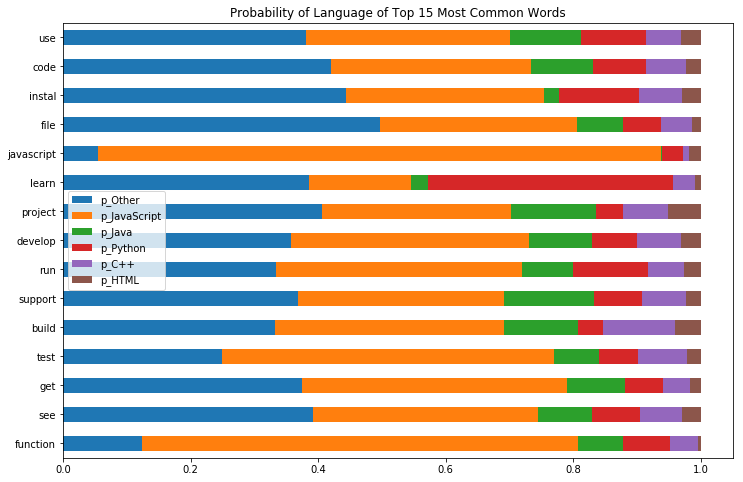

In [33]:
lang_prob = top_words[["all"]].copy()
for lang in top_words.drop(columns="all"):
    lang_prob[f"p_{lang}"] = top_words[lang] / top_words["all"]

lang_prob.sort_values(by="all").tail(15).drop(columns="all").plot.barh(
    stacked=True, figsize=(12, 8)
)
plt.title("Probability of Language of Top 15 Most Common Words")
plt.show()

Unsurprisingly, the most common words are representatively spread out among the categories

#### Word Cloud

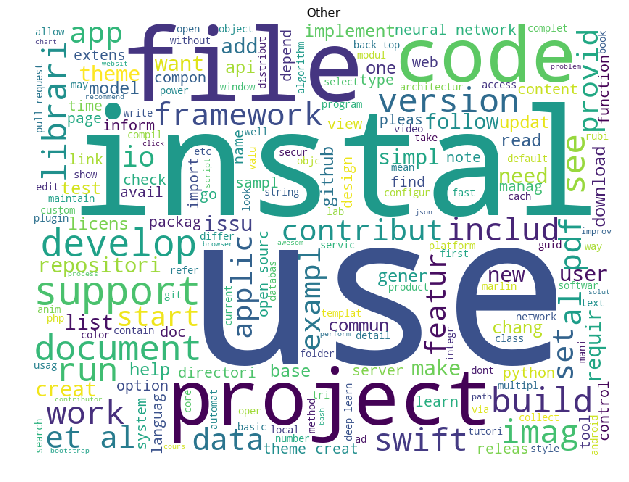

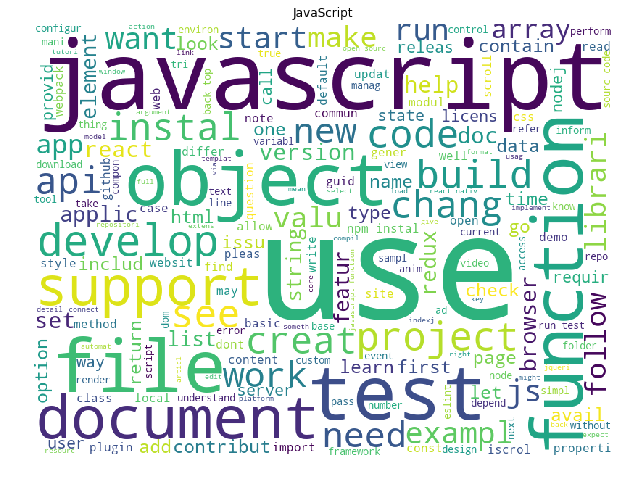

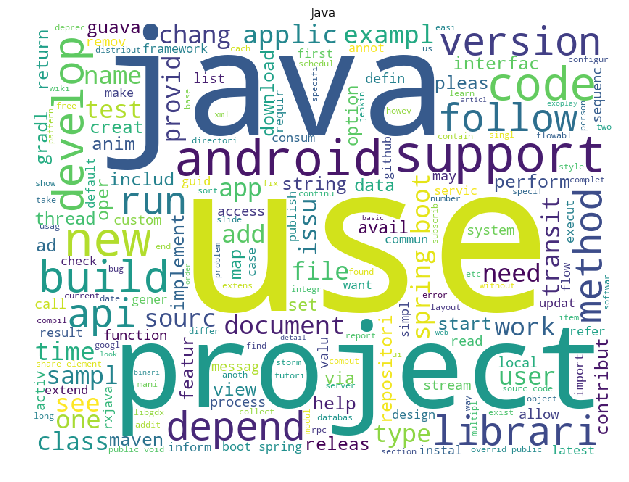

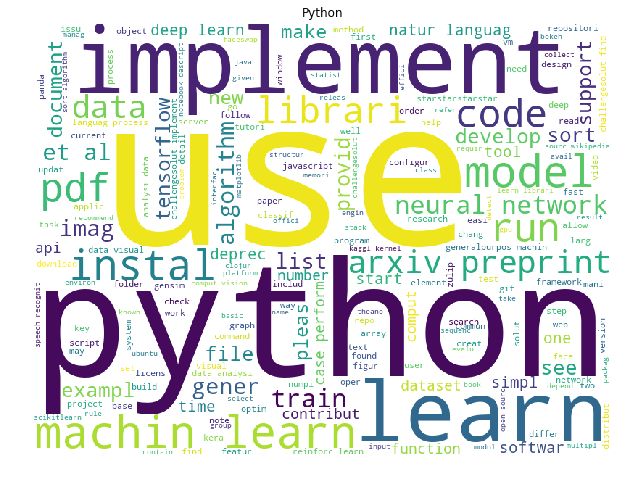

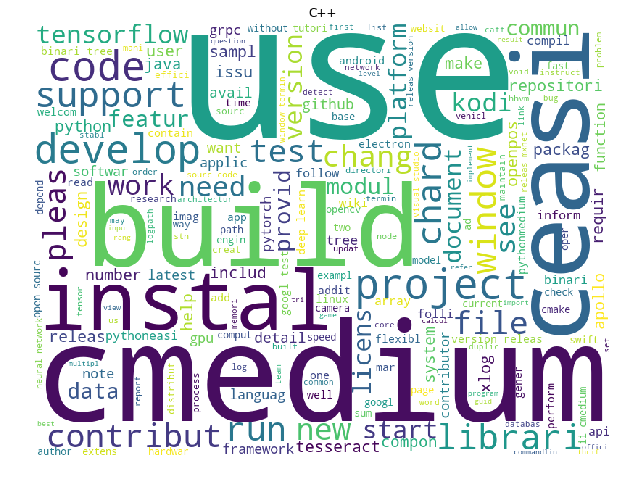

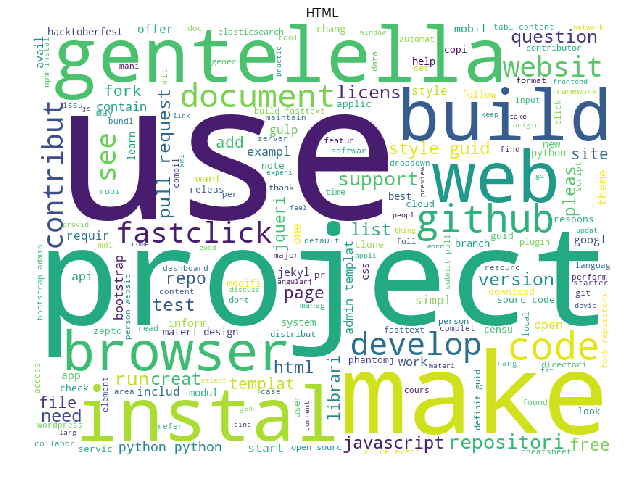

In [34]:
for lang, words in words_by_lang.items():
    plt.figure(figsize=(12, 8))
    cloud = WordCloud(
        background_color="white", height=600, width=800
    ).generate(words)
    plt.title(lang)
    plt.axis("off")
    plt.imshow(cloud)

**Conclusions**

"project", "use' are common words among the languages, but other than these, the most common words among the languages are different.

### Bigrams

**Most common bigrams and bar plot**

Other
(al, pdf)            165
(et, al)             165
(neural, network)    106
(open, sourc)         89
(theme, creat)        85
dtype: int64


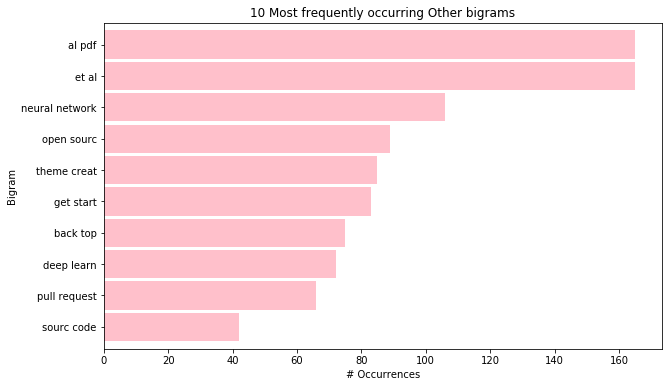

JavaScript
(get, start)     102
(npm, instal)     81
(back, top)       60
(sourc, code)     52
(run, test)       52
dtype: int64


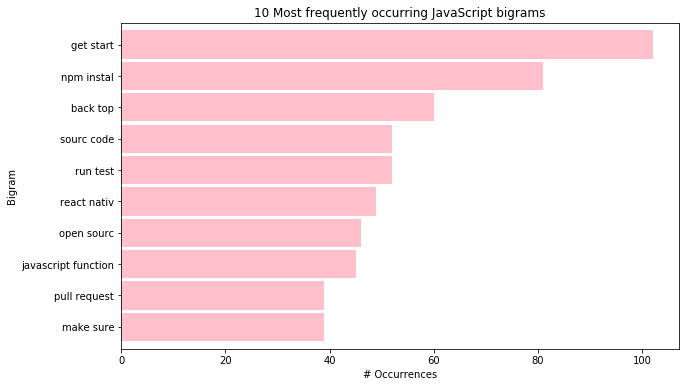

Java
(spring, boot)       52
(boot, spring)       24
(overrid, public)    23
(public, void)       21
(sourc, code)        19
dtype: int64


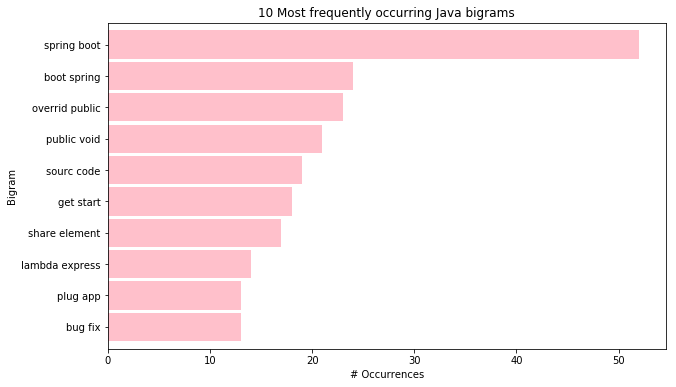

Python
(machin, learn)      112
(arxiv, preprint)     80
(neural, network)     79
(et, al)              65
(deep, learn)         45
dtype: int64


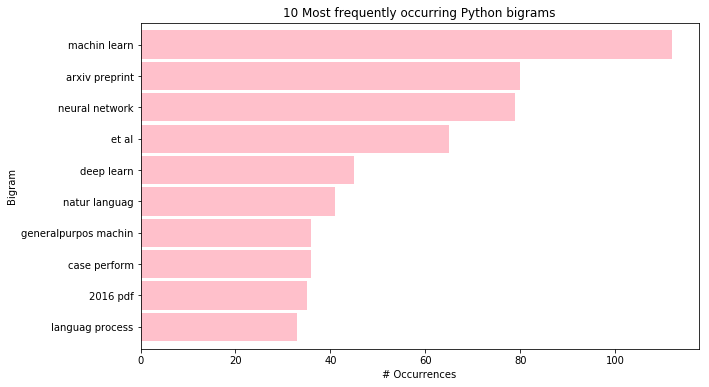

C++
(binari, tree)    17
(googl, test)     16
(deep, learn)     16
(ii, cmedium)     14
(open, sourc)     14
dtype: int64


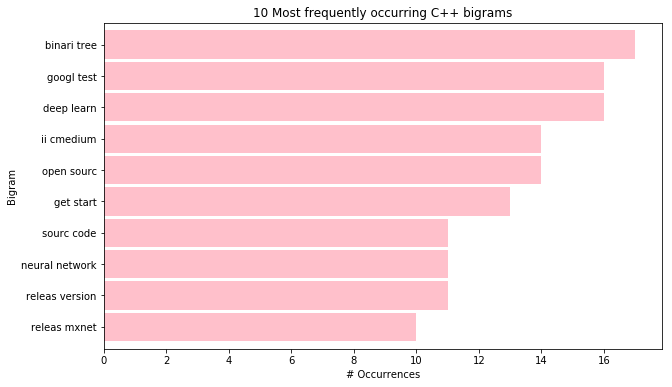

HTML
(pull, request)     16
(style, guid)       15
(python, python)    11
(admin, templat)    11
(materi, design)     8
dtype: int64


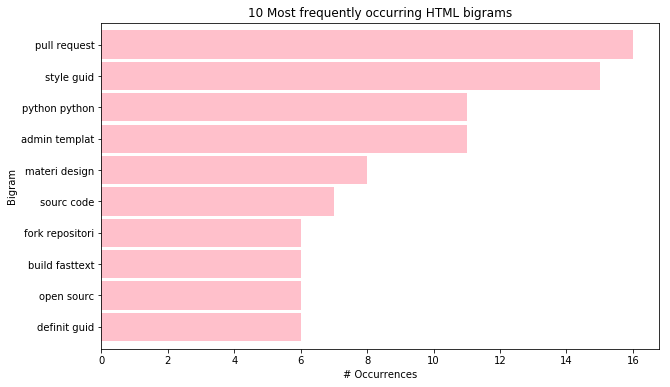

In [35]:
for lang, words in words_by_lang.items():
    bigrams = pd.Series(nltk.ngrams(words.split(), 2)).value_counts()
    print(f"{lang}\n{bigrams.head()}")

    # Bar plot the bigrams
    bigrams.sort_values().tail(10).plot.barh(
        color="pink", width=0.9, figsize=(10, 6)
    )

    plt.title(f"10 Most frequently occurring {lang} bigrams")
    plt.ylabel("Bigram")
    plt.xlabel("# Occurrences")

    # make the labels pretty
    ticks, _ = plt.yticks()
    labels = (
        bigrams.sort_values()
        .tail(10)
        .reset_index()["index"]
        .apply(lambda t: " ".join(t))
    )
    _ = plt.yticks(ticks, labels)
    plt.show()

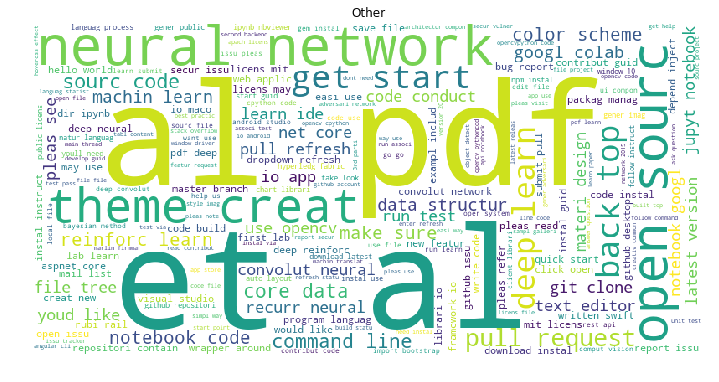

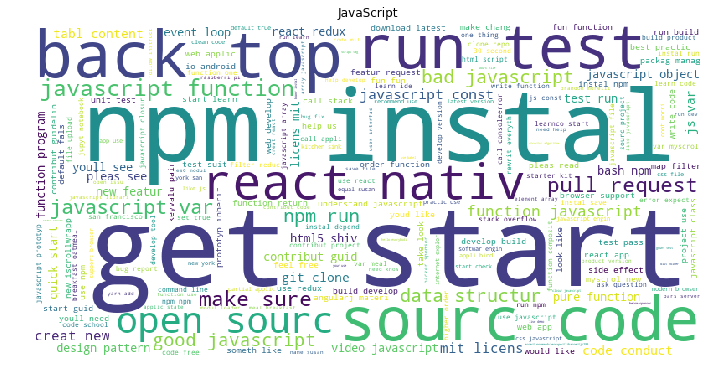

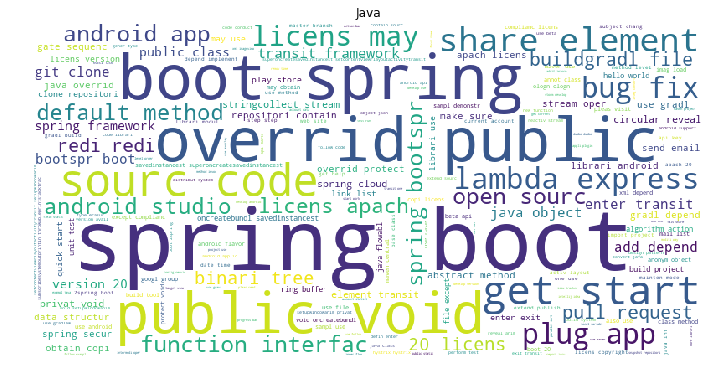

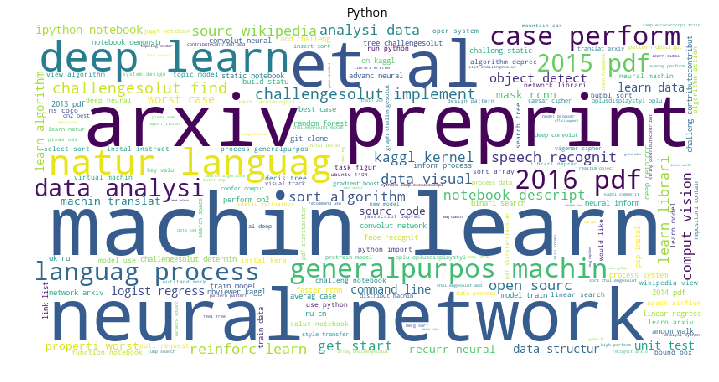

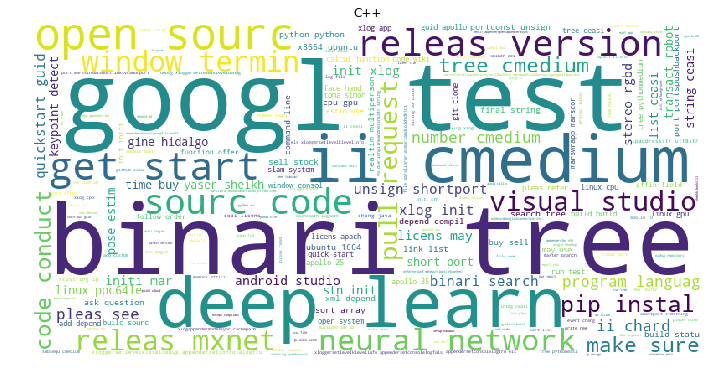

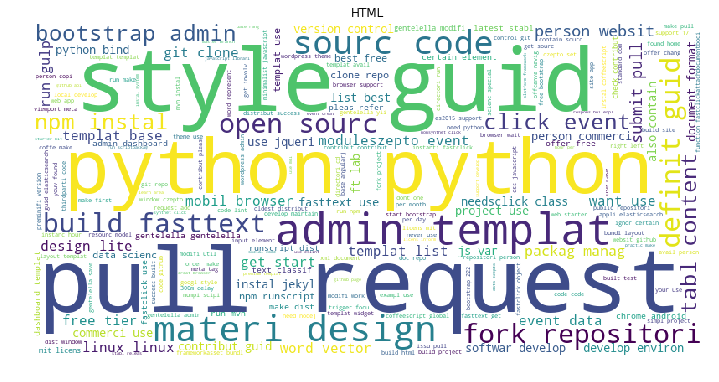

In [36]:
for lang, words in words_by_lang.items():
    bigrams = pd.Series(nltk.ngrams(words.split(), 2)).value_counts()

    # word cloud
    data = {" ".join(k): v for k, v in bigrams.to_dict().items()}
    img = WordCloud(
        background_color="white", width=800, height=400
    ).generate_from_frequencies(data)
    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.title(lang)
    plt.imshow(img)

**Conclusions**

There is overlap among the languages as to the most common bigrams. The brigrams may not be that helpful after all.

### Trigram

Other
(et, al, pdf)                  160
(notebook, googl, colab)        27
(convolut, neural, network)     24
(recurr, neural, network)       21
(deep, neural, network)         18
dtype: int64


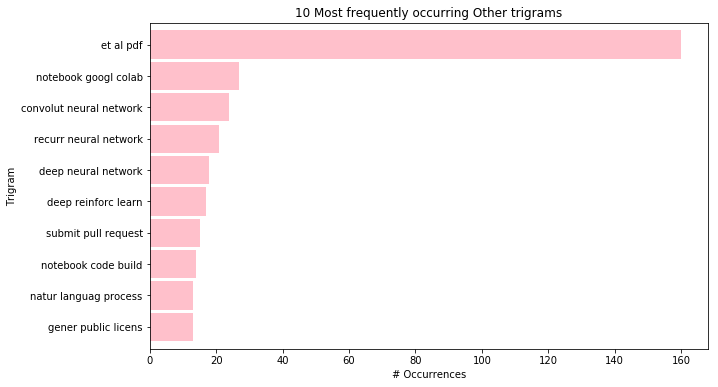

JavaScript
(bash, npm, instal)             15
(good, javascript, function)    14
(myscrol, new, iscrollwrapp)    14
(get, start, guid)              13
(fun, fun, function)            13
dtype: int64


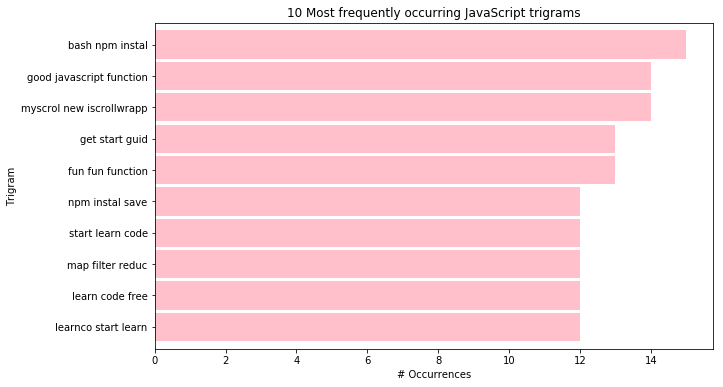

Java
(overrid, public, void)      20
(spring, boot, spring)       20
(boot, spring, boot)         14
(spring, bootspr, boot)       9
(share, element, transit)     8
dtype: int64


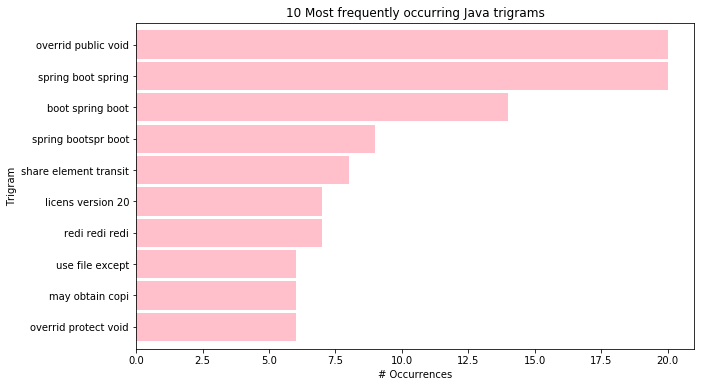

Python
(generalpurpos, machin, learn)    34
(natur, languag, process)         33
(data, analysi, data)             19
(analysi, data, visual)           18
(recurr, neural, network)         12
dtype: int64


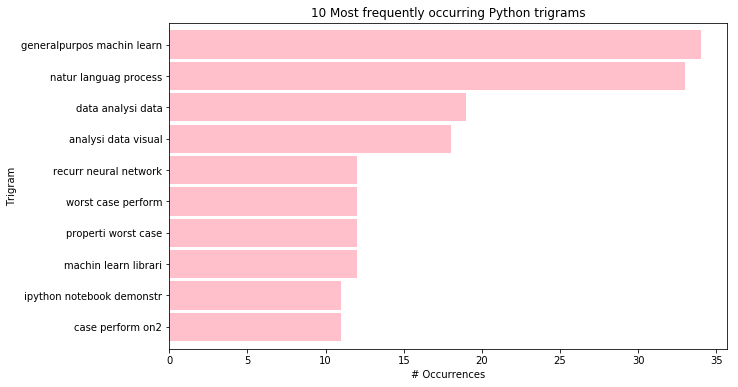

C++
(xml, depend, compil)             6
(buy, sell, stock)                6
(time, buy, sell)                 6
(portconst, unsign, shortport)    6
(quickstart, guid, apollo)        5
dtype: int64


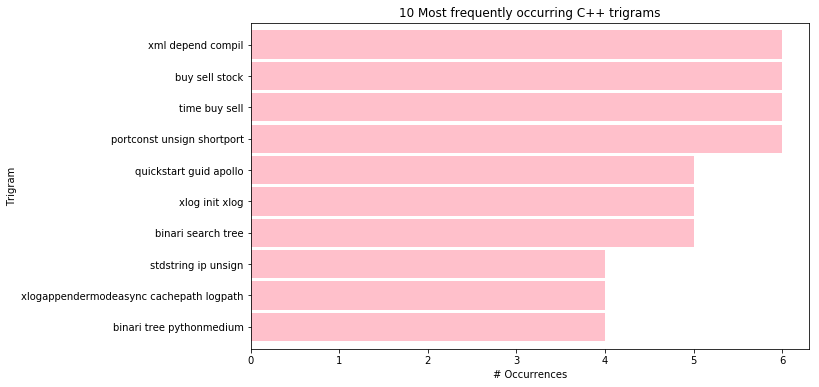

HTML
(python, python, python)       7
(submit, pull, request)        5
(moduleszepto, event, data)    4
(bootstrap, admin, templat)    4
(materi, design, lite)         4
dtype: int64


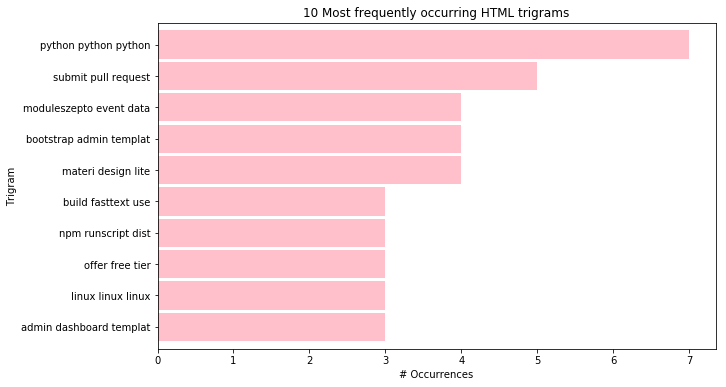

In [37]:
for lang, words in words_by_lang.items():
    trigrams = pd.Series(nltk.ngrams(words.split(), 3)).value_counts()
    print(f"{lang}\n{trigrams.head()}")

    # Bar plot the trigrams
    trigrams.sort_values().tail(10).plot.barh(
        color="pink", width=0.9, figsize=(10, 6)
    )

    plt.title(f"10 Most frequently occurring {lang} trigrams")
    plt.ylabel("Trigram")
    plt.xlabel("# Occurrences")

    # make the labels pretty
    ticks, _ = plt.yticks()
    labels = (
        trigrams.sort_values()
        .tail(10)
        .reset_index()["index"]
        .apply(lambda t: " ".join(t))
    )
    _ = plt.yticks(ticks, labels)
    plt.show()

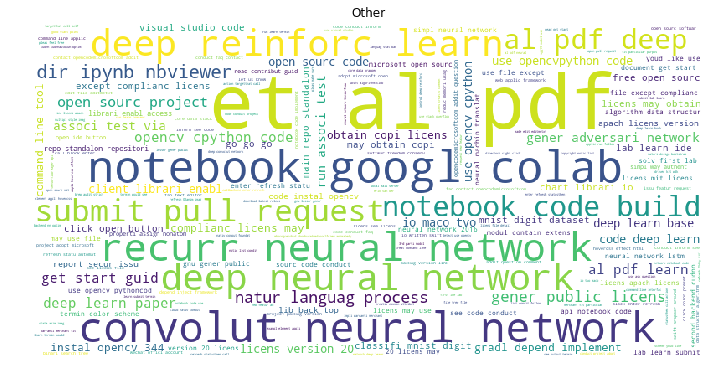

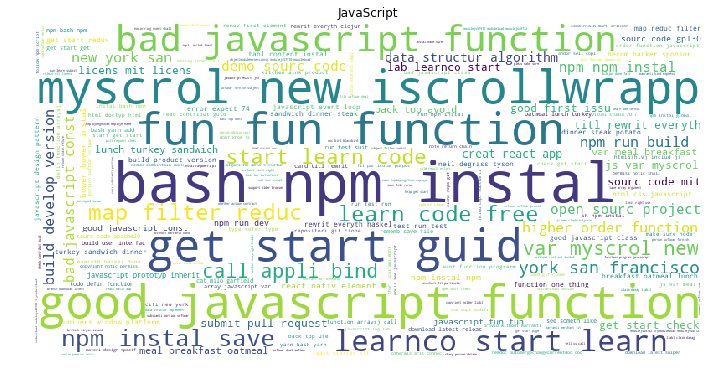

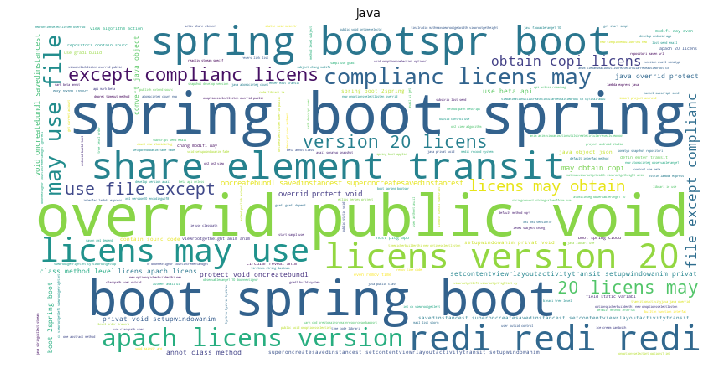

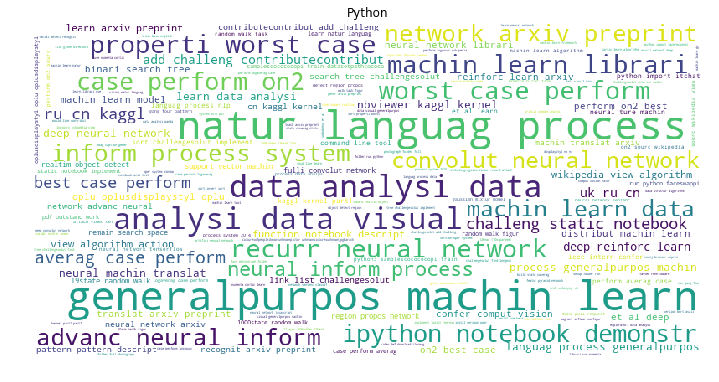

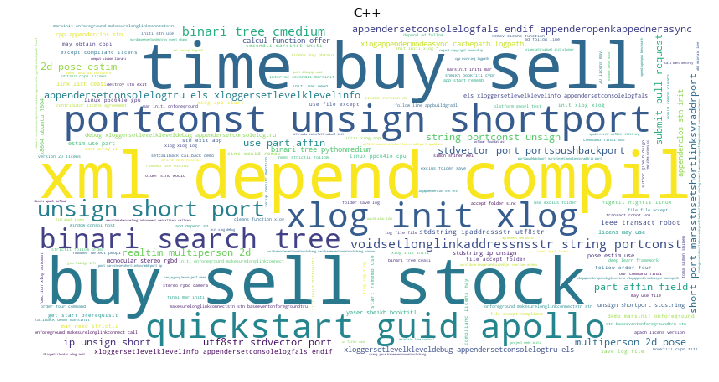

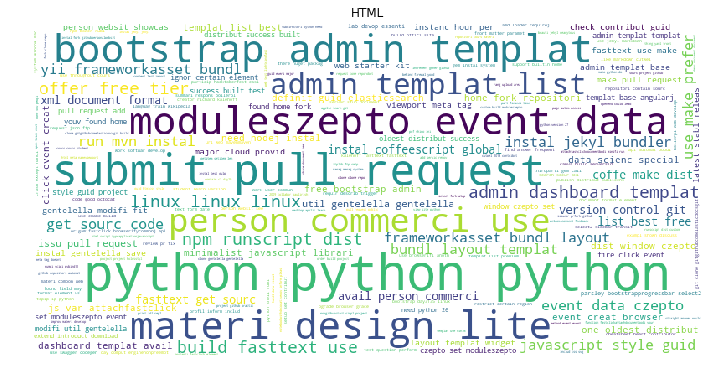

In [38]:
for lang, words in words_by_lang.items():
    trigrams = pd.Series(nltk.ngrams(words.split(), 3)).value_counts()

    # word cloud
    data = {" ".join(k): v for k, v in trigrams.to_dict().items()}
    img = WordCloud(
        background_color="white", width=800, height=400
    ).generate_from_frequencies(data)
    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.title(lang)
    plt.imshow(img)

**Conclusion**


While there is less overlap of the most common trigrams than bigrams, these appear to be mostly junk or unique to a specific repo. 

### Summarize Conclusions

## Modeling <a name="modeling"></a>

In [39]:
def confmatrix(y_actual, y_pred):
    df = pd.DataFrame(dict(actual=y_actual, predicted=y_pred))
    return pd.crosstab(df.predicted, df.actual)

### Train test split

In [40]:
print("before removal", len(df))
df = df[df.lang_grouped.isin(top_five)]
print("after removal", len(df))

before removal 783
after removal 492


In [41]:
df.lang_grouped.value_counts()

JavaScript    219
Java          118
Python         75
C++            43
HTML           37
Name: lang_grouped, dtype: int64

**Clean gives better results than lemmatized or stemmed**

In [42]:
# X_train, X_test, y_train, y_test = train_test_split(
#     df.lemmatized, df.lang_grouped, stratify=df.lang_grouped, test_size=0.2, random_state=123
# )

# X_train, X_test, y_train, y_test = train_test_split(
#     df.stemmed, df.lang_grouped, stratify=df.lang_grouped, test_size=0.2, random_state=123
# )

X_train, X_test, y_train, y_test = train_test_split(
    df.clean, df.lang_grouped, stratify=df.lang_grouped, test_size=0.2, random_state=123
)

In [43]:
X_train.shape

(393,)

In [44]:
X_train.head()

665    fastclick fastclick simple easytouse library e...
512    material design angularjs apps material design...
240    using conditionals multiple files js know use ...
873    awesomeselfhosted selfhosting process locally ...
187    extreme gradient boosting community documentat...
Name: clean, dtype: object

In [45]:
type(X_train)

pandas.core.series.Series

### For ALL Words

### Calculate TF-IDF for each word

In [46]:
tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(X_train)
df_tfidf = pd.DataFrame(train_tfidf.todense(), columns=tfidf.get_feature_names())

test_tfidf = tfidf.transform(X_test)

In [47]:
train_tfidf.shape

(393, 15925)

In [48]:
with open("tfidf.obj", 'wb') as fp:
    pickle.dump(tfidf, fp)

**Words with highest tf-idf**

In [49]:
df_tfidf.max().sort_values(ascending=False).head(10)

amp               0.892163
redux             0.868846
phonegap          0.866948
bokeh             0.864869
edx               0.864315
pixijs            0.849886
v8                0.844230
deeplearning4j    0.833144
libgdx            0.824854
brackets          0.824725
dtype: float64

**Words with lowest tf-idf**

In [50]:
df_tfidf.max().sort_values(ascending=False).tail(10)

visualising    0.005152
lazaris        0.005152
aston          0.005152
ivan           0.005152
rob            0.004954
koch           0.004954
grasp          0.004954
joseph         0.004954
preventing     0.004954
intervals      0.004954
dtype: float64

**What does the distribution look like?**

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


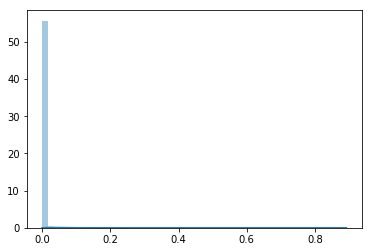

In [51]:
sns.distplot(train_tfidf.todense().flatten())

### KNN

In [52]:
def knnmodel(X_train, X_test, y_train, y_test, **kwargs):
    ks = range(1, 15)
    sse = []
    for k in ks:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X_train)

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_)

    print(pd.DataFrame(dict(k=ks, sse=sse)))

    plt.plot(ks, sse, "bx-")
    plt.xlabel("k")
    plt.ylabel("SSE")
    plt.title("The Elbow Method showing the optimal k")
    plt.show()
    
    knn = KNeighborsClassifier(**kwargs)
    knn.fit(X_train, y_train)
    y_pred_train = knn.predict(X_train)
    y_pred_proba_train = knn.predict_proba(X_train)
    
    print("TRAIN")
    print()
    print(
        "Accuracy of KNN classifier on training set: {:.2f}".format(
        knn.score(X_train, y_train)
        )
    )
    print()
    confmatrix(y_train, y_pred_train)
    print()
    print(classification_report(y_train, y_pred_train))
    
    y_pred_test = knn.predict(X_test)
    y_pred_proba_test = knn.predict_proba(X_test)
    
    print("-" * 20)
    print()
    print("TEST")
    print()
    print(
        "Accuracy of KNN classifier on training set: {:.2f}".format(
        knn.score(X_test, y_test)
        )
    )
    print()
    confmatrix(y_test, y_pred_test)
    print()
    print(classification_report(y_test, y_pred_test))
    
    k_range = range(1, 20)
    scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        scores.append(knn.score(X_test, y_test))
    plt.figure()
    plt.xlabel("k")
    plt.ylabel("accuracy")
    plt.scatter(k_range, scores)
    # plt.xticks([0,5,10,15,20])
    
    return knn

     k         sse
0    1  383.725577
1    2  381.236419
2    3  379.489902
3    4  378.247689
4    5  375.997555
5    6  374.762915
6    7  373.149021
7    8  371.540744
8    9  369.901062
9   10  368.364215
10  11  366.810997
11  12  365.514944
12  13  363.557530
13  14  362.734722


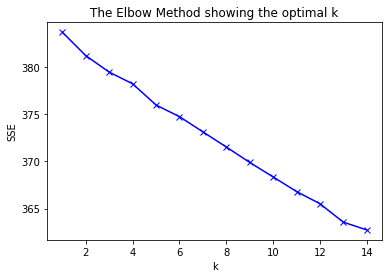

TRAIN

Accuracy of KNN classifier on training set: 0.78


              precision    recall  f1-score   support

         C++       0.82      0.41      0.55        34
        HTML       0.76      0.43      0.55        30
        Java       0.75      0.81      0.78        94
  JavaScript       0.79      0.93      0.85       175
      Python       0.79      0.70      0.74        60

   micro avg       0.78      0.78      0.78       393
   macro avg       0.78      0.66      0.70       393
weighted avg       0.78      0.78      0.77       393

--------------------

TEST

Accuracy of KNN classifier on training set: 0.69


              precision    recall  f1-score   support

         C++       0.50      0.11      0.18         9
        HTML       0.67      0.29      0.40         7
        Java       0.67      0.75      0.71        24
  JavaScript       0.69      0.91      0.78        44
      Python       0.78      0.47      0.58        15

   micro avg       0.69      0.69      0.69     

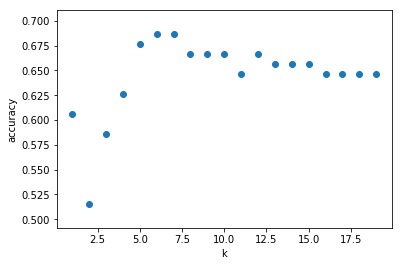

In [53]:
knn = knnmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_neighbors=6, weights="uniform")

In [54]:
with open("knnmodel.obj", 'wb') as fp:
    pickle.dump(knn, fp)

### Naive Bayes Model

In [55]:
def nbmodel(X_train, X_test, y_train, y_test, **kwargs):
    gnb = GaussianNB(**kwargs)
    gnb.fit(X_train, y_train)
    
    print("TRAIN")
    print()
    y_pred_train = gnb.predict(X_train)
    print(
        "Accuracy of GNB classifier on training set: {:.2f}".format(
            gnb.score(X_train, y_train)
        )
    )
    print()
    print(confmatrix(y_train, y_pred_train))
    print()
    print(classification_report(y_train, y_pred_train))
    
    print("-" * 20)
    print()
    print("TEST")
    print()
    y_pred_test = gnb.predict(X_test)
    print(
        "Accuracy of GNB classifier on training set: {:.2f}".format(
            gnb.score(X_test, y_test)
        )
    )
    print()
    print(confmatrix(y_test, y_pred_test))
    print()
    print(classification_report(y_test, y_pred_test))
    
    return gnb

In [56]:
nbmodel(train_tfidf.todense(), test_tfidf.todense(), y_train, y_test)

TRAIN

Accuracy of GNB classifier on training set: 0.99

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          34     0     1           0       0
HTML          0    30     0           1       0
Java          0     0    93           1       0
JavaScript    0     0     0         173       0
Python        0     0     0           0      60

              precision    recall  f1-score   support

         C++       0.97      1.00      0.99        34
        HTML       0.97      1.00      0.98        30
        Java       0.99      0.99      0.99        94
  JavaScript       1.00      0.99      0.99       175
      Python       1.00      1.00      1.00        60

   micro avg       0.99      0.99      0.99       393
   macro avg       0.99      1.00      0.99       393
weighted avg       0.99      0.99      0.99       393

--------------------

TEST

Accuracy of GNB classifier on training set: 0.56

actual      C++  HTML  Java  JavaScript

GaussianNB(priors=None, var_smoothing=1e-09)

### Logistic Regression

In [57]:
def lrmodel(X_train, X_test, y_train, y_test, **kwargs):
    lm = LogisticRegression(**kwargs).fit(X_train, y_train)
    
    print("TRAIN")
    print()
    y_pred_train = lm.predict(X_train)
    print(
        "Accuracy of lm classifier on training set: {:.2f}".format(
            accuracy_score(y_train, y_pred_train)
        )
    )
    print()
    print(confmatrix(y_train, y_pred_train))
    print()
    print(classification_report(y_train, y_pred_train))
    
    print("-" * 20)
    print()
    print("TEST")
    print()
    y_pred_test = lm.predict(X_test)
    print(
        "Accuracy of lm classifier on training set: {:.2f}".format(
            accuracy_score(y_test, y_pred_test)
        )
    )
    print()
    print(confmatrix(y_test, y_pred_test))
    print()
    print(classification_report(y_test, y_pred_test))
    
    return lm

In [58]:
lrmodel(train_tfidf, test_tfidf, y_train, y_test, random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced")

TRAIN

Accuracy of lm classifier on training set: 1.00

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          34     0     0           0       0
HTML          0    30     0           0       0
Java          0     0    94           1       0
JavaScript    0     0     0         174       0
Python        0     0     0           0      60

              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        34
        HTML       1.00      1.00      1.00        30
        Java       0.99      1.00      0.99        94
  JavaScript       1.00      0.99      1.00       175
      Python       1.00      1.00      1.00        60

   micro avg       1.00      1.00      1.00       393
   macro avg       1.00      1.00      1.00       393
weighted avg       1.00      1.00      1.00       393

--------------------

TEST

Accuracy of lm classifier on training set: 0.66

actual      C++  HTML  Java  JavaScript  

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=123, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

### Decision Tree

In [59]:
clf = DecisionTreeClassifier(
    criterion="entropy", max_depth=20, random_state=123, class_weight="balanced"
)

In [60]:
clf.fit(train_tfidf, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [61]:
y_pred = clf.predict(train_tfidf)
y_pred[0:5]

array(['HTML', 'JavaScript', 'JavaScript', 'JavaScript', 'C++'],
      dtype=object)

In [62]:
y_pred_proba = clf.predict_proba(train_tfidf)
# y_pred_proba

### Computing the accuracy of our model

In [63]:
print(
    "Accuracy of Decision Tree classifier on training set: {:.2f}".format(
        clf.score(train_tfidf, y_train)
    )
)

Accuracy of Decision Tree classifier on training set: 0.84


In [64]:
confmatrix(y_train, y_pred)

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          34     0     0           0       0
HTML          0    30     0           0       0
Java          0     0    70           0       0
JavaScript    0     0     0         136       0
Python        0     0    24          39      60

In [65]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        34
        HTML       1.00      1.00      1.00        30
        Java       1.00      0.74      0.85        94
  JavaScript       1.00      0.78      0.87       175
      Python       0.49      1.00      0.66        60

   micro avg       0.84      0.84      0.84       393
   macro avg       0.90      0.90      0.88       393
weighted avg       0.92      0.84      0.86       393



In [66]:
print(
    "Accuracy of Decision Tree classifier on test set: {:.2f}".format(
        clf.score(test_tfidf, y_test)
    )
)

Accuracy of Decision Tree classifier on test set: 0.45


### Random Forest

In [67]:
def rfmodel(X_train, X_test, y_train, y_test, **kwargs):
    clf = RandomForestClassifier(**kwargs).fit(X_train, y_train)
    
#     print("Feature Importances:")
#     print(clf.feature_importances_)
    print()
    print("TRAIN")
    print()
    y_pred_train = clf.predict(X_train)
    print(
        "Accuracy of clf classifier on training set: {:.2f}".format(
            accuracy_score(y_train, y_pred_train)
        )
    )
    print()
    print(confmatrix(y_train, y_pred_train))
    print()
    print(classification_report(y_train, y_pred_train))
    
    print("-" * 20)
    print()
    print("TEST")
    print()
    y_pred_test = clf.predict(X_test)
    print(
        "Accuracy of clf classifier on training set: {:.2f}".format(
            accuracy_score(y_test, y_pred_test)
        )
    )
    print()
    print(confmatrix(y_test, y_pred_test))
    print()
    print(classification_report(y_test, y_pred_test))
    
    return clf

In [68]:
rfmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_estimators=100,
    max_depth=10,
    random_state=123,
    class_weight="balanced",
)


TRAIN

Accuracy of clf classifier on training set: 0.90

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          27     0     0           0       0
HTML          0    27     0           0       0
Java          5     3    93          18      10
JavaScript    1     0     1         157       0
Python        1     0     0           0      50

              precision    recall  f1-score   support

         C++       1.00      0.79      0.89        34
        HTML       1.00      0.90      0.95        30
        Java       0.72      0.99      0.83        94
  JavaScript       0.99      0.90      0.94       175
      Python       0.98      0.83      0.90        60

   micro avg       0.90      0.90      0.90       393
   macro avg       0.94      0.88      0.90       393
weighted avg       0.92      0.90      0.90       393

--------------------

TEST

Accuracy of clf classifier on training set: 0.66

actual      C++  HTML  Java  JavaScrip

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)

### Excluding frequent words

### Calculate TF-IDF for each word

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.05)
train_tfidf = tfidf.fit_transform(X_train)
df_tfidf = pd.DataFrame(train_tfidf.todense(), columns=tfidf.get_feature_names())

test_tfidf = tfidf.transform(X_test)

In [70]:
train_tfidf.shape

(393, 15487)

**Words with highest tf-idf**

In [71]:
df_tfidf.max().sort_values(ascending=False).head(10)

jennic      1.000000
druid       1.000000
tornado     1.000000
docker      1.000000
hadoop      1.000000
amp         0.948052
phonegap    0.937788
edx         0.933346
redux       0.925166
bokeh       0.919290
dtype: float64

**Words with lowest tf-idf**

In [72]:
df_tfidf.max().sort_values(ascending=False).tail(10)

330patching    0.005317
roman          0.005317
32longest      0.005317
329longest     0.005317
328odd         0.005317
327count       0.005317
326power       0.005317
324wiggle      0.005317
322coin        0.005317
65valid        0.005317
dtype: float64

**What does the distribution look like?**

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


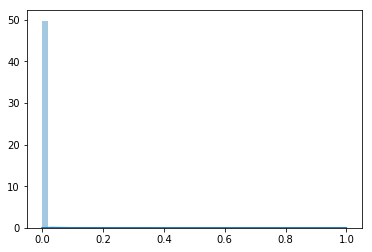

In [73]:
sns.distplot(train_tfidf.todense().flatten())

In [74]:
lrmodel(train_tfidf, test_tfidf, y_train, y_test, random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced")

TRAIN

Accuracy of lm classifier on training set: 0.99

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          34     0     0           1       0
HTML          0    30     0           0       0
Java          0     0    94           1       0
JavaScript    0     0     0         173       0
Python        0     0     0           0      60

              precision    recall  f1-score   support

         C++       0.97      1.00      0.99        34
        HTML       1.00      1.00      1.00        30
        Java       0.99      1.00      0.99        94
  JavaScript       1.00      0.99      0.99       175
      Python       1.00      1.00      1.00        60

   micro avg       0.99      0.99      0.99       393
   macro avg       0.99      1.00      0.99       393
weighted avg       1.00      0.99      0.99       393

--------------------

TEST

Accuracy of lm classifier on training set: 0.61

actual      C++  HTML  Java  JavaScript  

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=123, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [75]:
rfmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_estimators=1000,
    min_samples_leaf=3,
    max_depth=20,
    random_state=123,
    class_weight="balanced",
)


TRAIN

Accuracy of clf classifier on training set: 0.84

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          24     0     0           0       0
HTML          0    23     0           2       0
Java          9     6    93          28      12
JavaScript    0     0     1         144       0
Python        1     1     0           1      48

              precision    recall  f1-score   support

         C++       1.00      0.71      0.83        34
        HTML       0.92      0.77      0.84        30
        Java       0.63      0.99      0.77        94
  JavaScript       0.99      0.82      0.90       175
      Python       0.94      0.80      0.86        60

   micro avg       0.84      0.84      0.84       393
   macro avg       0.90      0.82      0.84       393
weighted avg       0.89      0.84      0.85       393

--------------------

TEST

Accuracy of clf classifier on training set: 0.58

actual      C++  HTML  Java  JavaScrip

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)

### Excluding least frequent words

### Calculate TF-IDF for each word

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=0.01)
train_tfidf = tfidf.fit_transform(X_train)
df_tfidf = pd.DataFrame(train_tfidf.todense(), columns=tfidf.get_feature_names())

test_tfidf = tfidf.transform(X_test)

In [77]:
train_tfidf.shape

(393, 2343)

**Words with highest tf-idf**

In [78]:
df_tfidf.max().sort_values(ascending=False).head(10)

rpc         0.987327
redis       0.916160
redux       0.890571
api         0.875340
figure      0.869190
electron    0.866057
flux        0.862615
2015        0.856054
brackets    0.855243
python3     0.853684
dtype: float64

**Words with lowest tf-idf**

In [79]:
df_tfidf.max().sort_values(ascending=False).tail(10)

startup       0.035621
primitive     0.034957
finding       0.034058
31            0.033770
imagine       0.032834
combine       0.031986
anyway        0.031047
introduce     0.030553
said          0.028218
accomplish    0.027260
dtype: float64

**What does the distribution look like?**

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


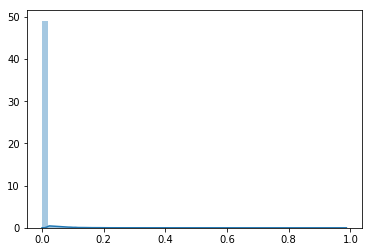

In [80]:
sns.distplot(train_tfidf.todense().flatten())

In [81]:
lm = lrmodel(train_tfidf, test_tfidf, y_train, y_test, random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced")

TRAIN

Accuracy of lm classifier on training set: 0.98

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          33     0     1           0       0
HTML          0    29     0           0       0
Java          1     0    93           3       0
JavaScript    0     0     0         169       0
Python        0     1     0           3      60

              precision    recall  f1-score   support

         C++       0.97      0.97      0.97        34
        HTML       1.00      0.97      0.98        30
        Java       0.96      0.99      0.97        94
  JavaScript       1.00      0.97      0.98       175
      Python       0.94      1.00      0.97        60

   micro avg       0.98      0.98      0.98       393
   macro avg       0.97      0.98      0.98       393
weighted avg       0.98      0.98      0.98       393

--------------------

TEST

Accuracy of lm classifier on training set: 0.70

actual      C++  HTML  Java  JavaScript  

In [82]:
rfmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_estimators=1000,
    min_samples_leaf=3,
    max_depth=20,
    random_state=123,
    class_weight="balanced",
)


TRAIN

Accuracy of clf classifier on training set: 0.93

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          33     0     0           0       0
HTML          0    27     0           1       0
Java          1     2    94          17       5
JavaScript    0     0     0         157       0
Python        0     1     0           0      55

              precision    recall  f1-score   support

         C++       1.00      0.97      0.99        34
        HTML       0.96      0.90      0.93        30
        Java       0.79      1.00      0.88        94
  JavaScript       1.00      0.90      0.95       175
      Python       0.98      0.92      0.95        60

   micro avg       0.93      0.93      0.93       393
   macro avg       0.95      0.94      0.94       393
weighted avg       0.94      0.93      0.93       393

--------------------

TEST

Accuracy of clf classifier on training set: 0.67

actual      C++  HTML  Java  JavaScrip

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)

### Excluding most and least frequent words

### Calculate TF-IDF for each word

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=0.01, max_df=0.05)
train_tfidf = tfidf.fit_transform(X_train)
df_tfidf = pd.DataFrame(train_tfidf.todense(), columns=tfidf.get_feature_names())

test_tfidf = tfidf.transform(X_test)

In [84]:
train_tfidf.shape

(393, 1905)

**Words with highest tf-idf**

In [85]:
df_tfidf.max().sort_values(ascending=False).head(10)

pattern       1.0
hadoop        1.0
python3       1.0
promise       1.0
middleware    1.0
progress      1.0
docker        1.0
starter       1.0
renamed       1.0
druid         1.0
dtype: float64

**Words with lowest tf-idf**

In [86]:
df_tfidf.max().sort_values(ascending=False).tail(10)

reasonable    0.047416
seem          0.045771
imagine       0.045688
finding       0.043417
introduce     0.043146
said          0.042101
anyway        0.042101
accomplish    0.040670
31            0.038665
combine       0.037891
dtype: float64

**What does the distribution look like?**

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


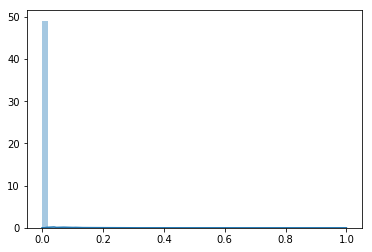

In [87]:
sns.distplot(train_tfidf.todense().flatten())

In [88]:
lrmodel(train_tfidf, test_tfidf, y_train, y_test, random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced")

TRAIN

Accuracy of lm classifier on training set: 0.96

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          33     0     1           1       0
HTML          0    30     1           2       0
Java          0     0    88           1       0
JavaScript    1     0     4         169       2
Python        0     0     0           2      58

              precision    recall  f1-score   support

         C++       0.94      0.97      0.96        34
        HTML       0.91      1.00      0.95        30
        Java       0.99      0.94      0.96        94
  JavaScript       0.96      0.97      0.96       175
      Python       0.97      0.97      0.97        60

   micro avg       0.96      0.96      0.96       393
   macro avg       0.95      0.97      0.96       393
weighted avg       0.96      0.96      0.96       393

--------------------

TEST

Accuracy of lm classifier on training set: 0.67

actual      C++  HTML  Java  JavaScript  

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=123, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [89]:
rfmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_estimators=100,
    max_depth=20,
    random_state=123,
    class_weight="balanced",
)


TRAIN

Accuracy of clf classifier on training set: 0.92

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          28     0     0           0       0
HTML          0    26     0           0       0
Java          0     1    82           1       2
JavaScript    6     3    12         174       8
Python        0     0     0           0      50

              precision    recall  f1-score   support

         C++       1.00      0.82      0.90        34
        HTML       1.00      0.87      0.93        30
        Java       0.95      0.87      0.91        94
  JavaScript       0.86      0.99      0.92       175
      Python       1.00      0.83      0.91        60

   micro avg       0.92      0.92      0.92       393
   macro avg       0.96      0.88      0.91       393
weighted avg       0.93      0.92      0.92       393

--------------------

TEST

Accuracy of clf classifier on training set: 0.62

actual      C++  HTML  Java  JavaScrip

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)

**Conclusions**

Results are very mixed when excluding the most and/or least frequent words. Sometimes the results of the model improve and sometimes they get worse.

### Using Bigrams as features

### TF-IDF

In [90]:
TOP_NBIGRAMS = 5_000
# top_nwords = top_words.sort_values(by="all", ascending=False).head(500)
# top_nwords.index.values

### Calculate TF-IDF for each word

In [91]:
tfidf = TfidfVectorizer(
    strip_accents="unicode", max_features=TOP_NBIGRAMS, ngram_range=(2, 2)
)
# tfidf = TfidfVectorizer(
#     strip_accents="unicode", ngram_range=(2, 2)
# )
train_tfidf = tfidf.fit_transform(X_train)
df_tfidf = pd.DataFrame(train_tfidf.todense(), columns=tfidf.get_feature_names())

test_tfidf = tfidf.transform(X_test)

In [92]:
train_tfidf.shape

(393, 5000)

In [93]:
test_tfidf.shape

(99, 5000)

In [94]:
df_tfidf.max().sort_values(ascending=False).head(10)

unless know             1.0
jack cui                1.0
logistic regression     1.0
live demo               1.0
web app                 1.0
official website        1.0
examples see            1.0
license mit             1.0
documentation source    1.0
official site           1.0
dtype: float64

In [95]:
df_tfidf.max().sort_values(ascending=False).tail(10)

international publishing    0.017291
trained network             0.017291
pdf iclr                    0.017291
pdf basic                   0.017291
oriol et                    0.017291
networks natural            0.017291
ieee conference             0.017291
filter javascript           0.011250
training deep               0.009086
statistical machine         0.009086
dtype: float64

**What does the distribution look like?**

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


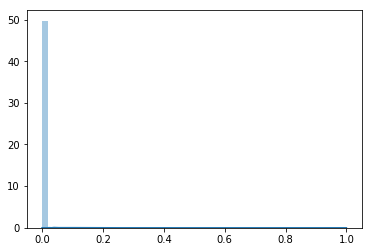

In [96]:
sns.distplot(train_tfidf.todense().flatten())

### Naive Bayes Model

In [97]:
nbmodel(train_tfidf.todense(), test_tfidf.todense(), y_train, y_test)

TRAIN

Accuracy of GNB classifier on training set: 0.92

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          32     0     1           1       0
HTML          2    30     9          10       6
Java          0     0    84           2       0
JavaScript    0     0     0         161       0
Python        0     0     0           1      54

              precision    recall  f1-score   support

         C++       0.94      0.94      0.94        34
        HTML       0.53      1.00      0.69        30
        Java       0.98      0.89      0.93        94
  JavaScript       1.00      0.92      0.96       175
      Python       0.98      0.90      0.94        60

   micro avg       0.92      0.92      0.92       393
   macro avg       0.89      0.93      0.89       393
weighted avg       0.95      0.92      0.93       393

--------------------

TEST

Accuracy of GNB classifier on training set: 0.57

actual      C++  HTML  Java  JavaScript

GaussianNB(priors=None, var_smoothing=1e-09)

### Logistic Regression

In [98]:
lrmodel(train_tfidf, test_tfidf, y_train, y_test,
    random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced",
)

TRAIN

Accuracy of lm classifier on training set: 0.96

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          33     0     0           1       0
HTML          0    28     0           1       0
Java          0     0    88           0       0
JavaScript    1     2     6         172       5
Python        0     0     0           1      55

              precision    recall  f1-score   support

         C++       0.97      0.97      0.97        34
        HTML       0.97      0.93      0.95        30
        Java       1.00      0.94      0.97        94
  JavaScript       0.92      0.98      0.95       175
      Python       0.98      0.92      0.95        60

   micro avg       0.96      0.96      0.96       393
   macro avg       0.97      0.95      0.96       393
weighted avg       0.96      0.96      0.96       393

--------------------

TEST

Accuracy of lm classifier on training set: 0.59

actual      C++  HTML  Java  JavaScript  

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=123, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

### Random Forest

In [99]:
rfmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_estimators=100, max_depth=20, random_state=123, class_weight="balanced"
)


TRAIN

Accuracy of clf classifier on training set: 0.81

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          27     0     0           0       0
HTML          0    26     0           0       0
Java          7     4    94          48      15
JavaScript    0     0     0         127       0
Python        0     0     0           0      45

              precision    recall  f1-score   support

         C++       1.00      0.79      0.89        34
        HTML       1.00      0.87      0.93        30
        Java       0.56      1.00      0.72        94
  JavaScript       1.00      0.73      0.84       175
      Python       1.00      0.75      0.86        60

   micro avg       0.81      0.81      0.81       393
   macro avg       0.91      0.83      0.85       393
weighted avg       0.89      0.81      0.82       393

--------------------

TEST

Accuracy of clf classifier on training set: 0.52

actual      C++  HTML  Java  JavaScrip

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)

### Bag of Words

In [100]:
vectorizer = CountVectorizer(max_features=750)
train_bow = vectorizer.fit_transform(X_train)
test_bow = vectorizer.transform(X_test)

df_bow = pd.DataFrame(train_bow.todense(), columns=vectorizer.get_feature_names())

In [101]:
train_bow.shape

(393, 750)

**Most common wordsf**

In [102]:
df_bow.sum().sort_values(ascending=False).head(10)

javascript    679
use           556
code          479
using         422
data          334
project       326
see           312
new           301
install       299
learning      295
dtype: int64

**Least common words**

In [103]:
df_bow.sum().sort_values(ascending=False).tail(10)

say           21
tesseract     21
goal          21
matplotlib    21
steps         21
middleware    21
admin         21
special       21
framework7    21
interested    21
dtype: int64

In [104]:
nbmodel(train_bow.todense(), test_bow.todense(), y_train, y_test)

TRAIN

Accuracy of GNB classifier on training set: 0.76

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          24     0     1           3       8
HTML          2    30    13          17       4
Java          8     0    80          20      13
JavaScript    0     0     0         129       0
Python        0     0     0           6      35

              precision    recall  f1-score   support

         C++       0.67      0.71      0.69        34
        HTML       0.45      1.00      0.62        30
        Java       0.66      0.85      0.74        94
  JavaScript       1.00      0.74      0.85       175
      Python       0.85      0.58      0.69        60

   micro avg       0.76      0.76      0.76       393
   macro avg       0.73      0.78      0.72       393
weighted avg       0.83      0.76      0.77       393

--------------------

TEST

Accuracy of GNB classifier on training set: 0.48

actual      C++  HTML  Java  JavaScript

GaussianNB(priors=None, var_smoothing=1e-09)

In [105]:
lrmodel(train_bow, test_bow, y_train, y_test, random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced")

TRAIN

Accuracy of lm classifier on training set: 0.99

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          34     0     0           0       0
HTML          0    30     0           0       0
Java          0     0    94           2       1
JavaScript    0     0     0         171       0
Python        0     0     0           2      59

              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        34
        HTML       1.00      1.00      1.00        30
        Java       0.97      1.00      0.98        94
  JavaScript       1.00      0.98      0.99       175
      Python       0.97      0.98      0.98        60

   micro avg       0.99      0.99      0.99       393
   macro avg       0.99      0.99      0.99       393
weighted avg       0.99      0.99      0.99       393

--------------------

TEST

Accuracy of lm classifier on training set: 0.62

actual      C++  HTML  Java  JavaScript  

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=123, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [106]:
rfmodel(train_bow, test_bow, y_train, y_test,
    n_estimators=200, max_depth=10, random_state=123, class_weight="balanced"
)


TRAIN

Accuracy of clf classifier on training set: 0.91

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          29     0     0           0       0
HTML          1    27     0           3       1
Java          4     3    94          16       8
JavaScript    0     0     0         156       0
Python        0     0     0           0      51

              precision    recall  f1-score   support

         C++       1.00      0.85      0.92        34
        HTML       0.84      0.90      0.87        30
        Java       0.75      1.00      0.86        94
  JavaScript       1.00      0.89      0.94       175
      Python       1.00      0.85      0.92        60

   micro avg       0.91      0.91      0.91       393
   macro avg       0.92      0.90      0.90       393
weighted avg       0.93      0.91      0.91       393

--------------------

TEST

Accuracy of clf classifier on training set: 0.65

actual      C++  HTML  Java  JavaScrip

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)

**Conclusions**

For the most part, bag of words performs worse than TF-IDF, except for the random forest model.